# Bootstrap analysis for training data
This notebook is to guide through the process of doing bootstrap analysis for the amount of training data i.e. duration of unique stimuli available for fitting the model.

Here is step by step process;

**1. Using different proportions of data to fit the model** \
Use /scripts/bootstrap_estimage.py to fit using different proportions of data. Specifically, this script allows using from 10% to 100% of training data to fit the model and saves the resulting correlations. For each proportion of data used, a separate file will be saved to the results directory, and we would want to repeat this mechanim to fit using varying amounts of data multiple times (hence the name bootstap) so it is critical to use naming convention for the files saved with correlation results. "bootstrap_training_data.sh" script implements an example of submitting jobs for all levels of data subsets (10 to 100%) to compute the results.

```
./bootstrap_training.sh "-m whisper_base -l 2 -d ucdavis -b 50 -i itr"
```
This will submit 10 jobs and results will be saved with identifiers; 
- $[ucdavis]\_timit\_trf\_lags300\_bw50\_boot\_[itr]\_10$
- $[ucdavis]\_timit\_trf\_lags300\_bw50\_boot\_[itr]\_20$
- $[ucdavis]\_timit\_trf\_lags300\_bw50\_boot\_[itr]\_30$
- $[ucdavis]\_timit\_trf\_lags300\_bw50\_boot\_[itr]\_40$
- $[ucdavis]\_timit\_trf\_lags300\_bw50\_boot\_[itr]\_50$
- $[ucdavis]\_timit\_trf\_lags300\_bw50\_boot\_[itr]\_60$
- $[ucdavis]\_timit\_trf\_lags300\_bw50\_boot\_[itr]\_70$
- $[ucdavis]\_timit\_trf\_lags300\_bw50\_boot\_[itr]\_80$
- $[ucdavis]\_timit\_trf\_lags300\_bw50\_boot\_[itr]\_90$
- $[ucdavis]\_timit\_trf\_lags300\_bw50\_boot\_[itr]\_100$

Do this 80 times, with specifying itr=1...80 to get 80 samples at each proportion of data.

**2. Compute normalizers for the sessions being analyzed** \
Make sure the normalizers are computed and saved to the memory for all the sessions (or at least the ones that are included in the bootstrap analysis). Sessions to be included in the bootsrap analysis can be specified within the script `bootstrap_estimate2.py`. In case there are large number of sessions being analysed, running this code as a batch script might be a better option. Nevertheless the code is a couple of lines of code as given below.

In [ ]:
from auditory_cortex.neural_data.normalizer_calculator import NormalizerCalculator
bin_width = 50
mVocs = True
session_ids = [0,1,2]
for sess_id in session_ids:
    normalizer = NormalizerCalculator('ucdavis', sess_id)

    dist = normalizer.get_normalizer_for_session_random_pairs(
        bin_width=bin_width, mVocs=mVocs
    )

**3. Compute null distribution for the dataset analyzed** \
Make sure the null distribution is computed and saved to the memory. Normally null distribution using random poisson sequences is used so one null distributions is computed for the entire stimulus set. It actually depends on the length of the long sequences (i.e. duration of repeated stimuli).

In [ ]:
from auditory_cortex.neural_data.normalizer_calculator import NormalizerCalculator
# any session id will work, as the stimuli are the same for all sessions in a dataset
sess_id = 0	
bin_width = 50
mVocs = True
num_itr=100000
normalizer = NormalizerCalculator('ucdavis', sess_id)
null_dist_ucdavis = normalizer.get_normalizer_null_dist_using_poisson(
    bin_width=bin_width, num_itr=num_itr, mVocs=mVocs)

**4. Combining results Adding normalizers to all the results saved in the first step** \
After we have saved all the results of the first step, and computed normalizer as well as null distribution, we can start analyzing the results of bootsrap analysis. The first step is to combine the results for different proportions of data into a single file, for each iteration, so that we have only one file for one iteration. Next we incorporate the normalizer into the saved results. For 80 iterations of bootsrap, we will have 80*10=800 files saved to the memory. After combining they would reduce to 80 and we'll then update the normalizer for each of these files in a loop. So I have written the helper functions to help with that. For now, I am defining them within this notebook, I might move them to a separate helper class.

In [1]:
import logging
from auditory_cortex.utils import set_up_logging
set_up_logging()

import numpy as np
from auditory_cortex.io_utils import ResultsManager
from auditory_cortex.analyses.correlations_analyzer import Correlations

def check_bootstrap_results(
    identifier, num_sessions, model_names=None, bin_width=50,
    verbose=False, percent_durations=None
    ):
    """Checks if the results for the given identifier and model names
    are done for all percent durations.
    """
    models_not_done = []
    if model_names is None:
        model_names = num_layers.keys()
    if percent_durations is None:
        percent_durations = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    for model_name in model_names:
        for dur in percent_durations:
            not_done = ResultsManager.check_results(
                model_name, f'{identifier}_{dur}',
                verbose=verbose, num_sessions=num_sessions
            )
            models_not_done.extend(not_done)

    # remove None entries..
    while None in models_not_done:
        models_not_done.remove(None)
    
    if len(models_not_done) ==0:
        logging.info(f"All models done..for {identifier}")
    else:
        logging.info(f"Models with incomplete resutls:")
        for iden in models_not_done:
            logging.info(iden)

def combine_bootstrap_results(
    identifier, model_names, percent_durations=None
    ):
    """For each model name, and given identifier, combines separate files
    for each percent duration into a single file.
    The output file is saved as model_name+'_' + identifier
    """
    if percent_durations is None:
        percent_durations = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    for model_name in model_names:
        ids = [f'{identifier}_{dur}' for dur in percent_durations]

        ResultsManager.merge_correlation_results(
            model_name,
            ids, 
            output_identifier=identifier
        )


In [2]:
model_names = [
    'whisper_base',
]
dataset_name = 'ucdavis'
mVocs = False
bin_width = 50
lag=200
num_sessions = 9
identifier = 'exp_design'
stim = 'mVocs' if mVocs else 'timit'
identifiers = [
    f'{dataset_name}_{stim}_trf_lags{lag}_bw{bin_width}_bootstrap_{identifier}_{i}'
     for i in range(1, 51)
    ]
percent_durations = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [ ]:
verbose=False
for identifier in identifiers:
    check_bootstrap_results(
        identifier, num_sessions, model_names=model_names, bin_width=bin_width,
        verbose=verbose, percent_durations=percent_durations
        )


if the above test is passed, that means all the files have the results for the sessions specified in the script. Now we can combine files for each iteration.

In [6]:
for identifier in identifiers:
    combine_bootstrap_results(identifier, model_names=model_names, percent_durations=percent_durations)

INFO:Combining results...
INFO:Output saved at: 
 /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_base_ucdavis_mVocs_trf_lags200_bw50_bootstrap_exp_design_1_corr_results.csv


In [4]:
mVocs = False
bin_width = 50
lag=200
identifier = 'exp_design'
stim = 'mVocs' if mVocs else 'timit'
identifiers = [
    f'{dataset_name}_{stim}_trf_lags{lag}_bw{bin_width}_bootstrap_{identifier}_{i}'
     for i in range(1, 51)
    ]

In [5]:
model_name = 'whisper_base'
for identifier in identifiers:
    corr_obj = Correlations(model_name+'_'+identifier)
    corr_obj.set_normalizers_using_bootsrap(mVocs=mVocs)
    print(f"Done for identifier: {identifier}")

INFO:Getting normalizer dist. for sess-0, bw-50, mVocs=False
INFO:Getting normalizer dist. for sess-1, bw-50, mVocs=False
INFO:Getting normalizer dist. for sess-2, bw-50, mVocs=False
INFO:Getting normalizer dist. for sess-3, bw-50, mVocs=False
INFO:Getting normalizer dist. for sess-4, bw-50, mVocs=False
INFO:Getting normalizer dist. for sess-5, bw-50, mVocs=False
INFO:Getting normalizer dist. for sess-6, bw-50, mVocs=False
INFO:Getting normalizer dist. for sess-7, bw-50, mVocs=False
INFO:Getting normalizer dist. for sess-8, bw-50, mVocs=False
INFO:Columns: 'normalizer', 'test_cc_raw', 'normalized_test_cc' updated using normalizer (random pairs) dist, writing back now...
INFO:Saved at /depot/jgmakin/data/auditory_cortex/results/cross_validated_correlations/whisper_base_ucdavis_timit_trf_lags200_bw50_bootstrap_exp_design_1_corr_results.csv
Done for identifier: ucdavis_timit_trf_lags200_bw50_bootstrap_exp_design_1
INFO:Getting normalizer dist. for sess-0, bw-50, mVocs=False
INFO:Getting n

**5. Computing medians of distributions and saving to disk**

In [13]:
from auditory_cortex.analyses.correlations_analyzer import Correlations
from auditory_cortex.io_utils import io
def get_medians_for_single_itr(corr_obj, bin_width=50, mVocs=False):

    threshold = corr_obj.get_normalizer_threshold(bin_width=bin_width, mVocs=mVocs)
    select_data = corr_obj.get_selected_data(threshold=threshold, bin_width=bin_width, mVocs=mVocs)
    if mVocs:
        column = 'mVocs_normalized_test_cc'
    else:
        column = 'normalized_test_cc'
    medians = {}
    N_sents = select_data['N_sents'].unique()
    for N in N_sents:
        medians[N] = select_data[select_data['N_sents'] == N][column].median()
    return medians

def get_median_dist_for_all_itr(identifiers, model_name, bin_width=50, mVocs=False):

    median_dists = {}
    for identifier in identifiers:
        corr_obj = Correlations(model_name+'_'+identifier)
        medians = get_medians_for_single_itr(corr_obj, bin_width=bin_width, mVocs=mVocs)
        for N, median in medians.items():
            if N not in median_dists:
                median_dists[N] = []
            median_dists[N].append(median)

    return median_dists

def get_bootstrap_medians(
    identifiers, model_name, dataset_name='ucsf', force_redo=False, test=False, mVocs=False
    ):
    if not force_redo:
        median_dist = io.read_bootstrap_median_dist(
            model_name, bin_width=50, mVocs=mVocs, verbose=True, test=test,
            dataset_name=dataset_name
            )
        if median_dist is not None:
            return median_dist
    median_dist = get_median_dist_for_all_itr(identifiers, model_name=model_name, bin_width=50, mVocs=mVocs)
    io.write_bootstrap_median_dist(
        median_dist, model_name, bin_width=50, mVocs=mVocs, test=test,
        dataset_name=dataset_name
        )
    return median_dist

In [14]:
dist = get_bootstrap_medians(identifiers, 'whisper_base', dataset_name='ucdavis', test=False, mVocs=True)

Applying threshold: 0.029 on column: 'mVocs_normalizer'...
Applying threshold: 0.029 on column: 'mVocs_normalizer'...
Applying threshold: 0.029 on column: 'mVocs_normalizer'...
Applying threshold: 0.029 on column: 'mVocs_normalizer'...
Applying threshold: 0.029 on column: 'mVocs_normalizer'...
Applying threshold: 0.029 on column: 'mVocs_normalizer'...
Applying threshold: 0.029 on column: 'mVocs_normalizer'...
Applying threshold: 0.029 on column: 'mVocs_normalizer'...
Applying threshold: 0.029 on column: 'mVocs_normalizer'...
Applying threshold: 0.029 on column: 'mVocs_normalizer'...
Applying threshold: 0.029 on column: 'mVocs_normalizer'...
Applying threshold: 0.029 on column: 'mVocs_normalizer'...
Applying threshold: 0.029 on column: 'mVocs_normalizer'...
Applying threshold: 0.029 on column: 'mVocs_normalizer'...
Applying threshold: 0.029 on column: 'mVocs_normalizer'...
Applying threshold: 0.029 on column: 'mVocs_normalizer'...
Applying threshold: 0.029 on column: 'mVocs_normalizer'.

**6. Plotting...**
- timit

Text(0.5, 1.0, "Bootstrap: training data for 'ucdavis' and 'timit'")

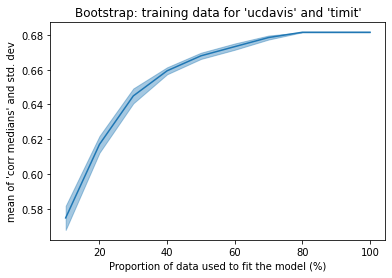

In [16]:
import numpy as np
import matplotlib.pyplot as plt

model_name = 'whisper_base'
dataset_name = 'ucdavis'
mVocs=False
test=False
bin_width = 50
if mVocs:
    stim = 'mVocs'
else:
    stim = 'timit'

identifiers = [f'{dataset_name}_{stim}_trf_lags300_bw{bin_width}_boot_{i}' for i in range(1, 81)]
median_dists = get_bootstrap_medians(
    identifiers, model_name, dataset_name=dataset_name, test=test, mVocs=mVocs)
proportion_of_data = list(median_dists.keys())
means = [np.mean(median_dists[N]) for N in proportion_of_data]
std_errors = [np.std(median_dists[N]) for N in proportion_of_data]

std_errors = np.array(std_errors)
plt.plot(proportion_of_data, means, label='Mean', color='tab:blue')

# Plot the standard error as shaded region
plt.fill_between(proportion_of_data, means - std_errors/2, means + std_errors/2, 
                 color='tab:blue', alpha=0.4, label='Standard Error')
plt.xlabel('Proportion of data used to fit the model (%)')
plt.ylabel("mean of 'corr medians' and std. dev")
plt.title(f"Bootstrap: training data for '{dataset_name}' and '{stim}'")

- mVocs

Text(0.5, 1.0, "Bootstrap: training data for 'ucdavis' and 'mVocs'")

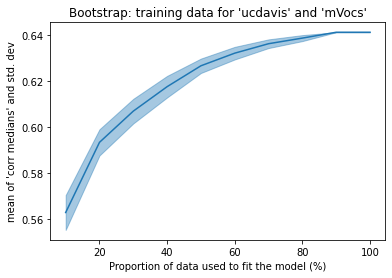

In [15]:
import numpy as np
import matplotlib.pyplot as plt

model_name = 'whisper_base'
dataset_name = 'ucdavis'
mVocs=True
test=False
bin_width = 50
if mVocs:
    stim = 'mVocs'
else:
    stim = 'timit'

identifiers = [f'{dataset_name}_{stim}_trf_lags300_bw{bin_width}_boot_{i}' for i in range(1, 81)]
median_dists = get_bootstrap_medians(
    identifiers, model_name, dataset_name=dataset_name, test=test, mVocs=mVocs)
proportion_of_data = list(median_dists.keys())
means = [np.mean(median_dists[N]) for N in proportion_of_data]
std_errors = [np.std(median_dists[N]) for N in proportion_of_data]

std_errors = np.array(std_errors)
plt.plot(proportion_of_data, means, label='Mean', color='tab:blue')

# Plot the standard error as shaded region
plt.fill_between(proportion_of_data, means - std_errors/2, means + std_errors/2, 
                 color='tab:blue', alpha=0.4, label='Standard Error')
plt.xlabel('Proportion of data used to fit the model (%)')
plt.ylabel("mean of 'corr medians' and std. dev")
plt.title(f"Bootstrap: training data for '{dataset_name}' and '{stim}'")